<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/AUEM/Taller_20241219/ESE_ANN_simple_L8_con_2020_hiperparametros2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensayo 2024.12.19

Actualización de hiperparámetros en dos modelos para comparar con básicos

## Ensenada
* Cargar Numpy arrays de predictores y variables categoricas de Google Drive
* Preparar los datos y normalizar predictores con StandardScaler
* Subdividir datos de entrenamiento, control y validación
* Entrenar dos modelos ANN para comparar
* Evaluar los modelos obtenidos
* Realizar predicción con mejor modelo en 2015, 2014 y 2020
* Guardar resultados en Google Drive en Numpy array y en GeoTIFF

In [1]:
## Definir variables

## Prefilo de zona
prefijo = "ESE"

## Ruta en Google Drive (se requiere crear una carpeta en raíz de Google Drive)
ruta = "Colab Data"

## Variables requeridos para guardar en GeoTIFF

## Proyeccion UTM aplicable
projection_text = "EPSG:32611"

## limites de rectangulo de zona de estudio en UTM
limites_utm = [523989, 548709, 3502560, 3532709]

## tamaño de pixel
pixel = 30

#### La prueba de modelos se lleva a cabo con distintos subconjuntos de hiperparámetros

In [74]:
## Definir los hiperparámetros
hiper = {"M1": {"epochs": 20,
                "batch": 500,
                "internal1": 40,
                "internal2": 10},
         "M2": {"epochs": 20,
                "batch": 50,
                "internal1": 40,
                "internal2": 10}}

#### Preparar el entorno

In [2]:
import random
from google.colab import drive
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
import tensorflow as tf
from tensorflow import keras
from osgeo import gdal, osr

!pip install pyrsgis
from pyrsgis import raster, convert


random_seed = 2
random.seed(random_seed)

## Inicializar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Lectura de datos de Google Drive

In [3]:
ruta_L8_2014 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2014_feature_L8_6b.npy"
print(ruta_L8_2014)

ruta_L8_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_feature_L8_6b.npy"
print(ruta_L8_2015)

ruta_L8_2020 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2020_feature_L8_6b.npy"
print(ruta_L8_2020)

ruta_target_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target.npy"
print(ruta_target_2015)

ruta_target_binary_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target_binary.npy"
print(ruta_target_binary_2015)

array_feature_2015 = np.load(ruta_L8_2015)
array_feature_2014 = np.load(ruta_L8_2014)
array_feature_2020 = np.load(ruta_L8_2020)
array_target_binary_2015 = np.load(ruta_target_2015)
array_target_2015 = np.load(ruta_target_2015)

/content/drive/MyDrive/Colab Data/ESE_2014_feature_L8_6b.npy
/content/drive/MyDrive/Colab Data/ESE_2015_feature_L8_6b.npy
/content/drive/MyDrive/Colab Data/ESE_2020_feature_L8_6b.npy
/content/drive/MyDrive/Colab Data/ESE_2015_target.npy
/content/drive/MyDrive/Colab Data/ESE_2015_target_binary.npy


#### Transformar datos para trabajo con el modelo

In [4]:
def feature_transform(source_array):
    print('Forma de array original:', source_array.shape)
    array_t = np.transpose(source_array, (2, 0, 1))
    table_array = convert.array_to_table(array_t)
    print('Forma de array transformada:', table_array.shape)
    return table_array

x_features_2020 = feature_transform(array_feature_2020)
x_features_2015 = feature_transform(array_feature_2015)
x_features_2014 = feature_transform(array_feature_2014)
y_labels_2015 = feature_transform(array_target_2015)
y_labels_binary_2015 = feature_transform(array_target_binary_2015)

Forma de array original: (1005, 824, 6)
Forma de array transformada: (828120, 6)
Forma de array original: (1005, 824, 6)
Forma de array transformada: (828120, 6)
Forma de array original: (1005, 824, 6)
Forma de array transformada: (828120, 6)
Forma de array original: (1005, 824, 1)
Forma de array transformada: (828120, 1)
Forma de array original: (1005, 824, 1)
Forma de array transformada: (828120, 1)


#### Estandarización de datos (predictores) con StandardScaler

In [5]:
scale = StandardScaler()
x_features_2020_n = scale.fit_transform(x_features_2020)
x_features_2014_n = scale.fit_transform(x_features_2014)
x_features_2015_n = scale.fit_transform(x_features_2015)

#### Visualización de patron de datos antes y despues de estandarización

In [6]:
print('Antes de normalización (2015)')
for arr in np.transpose(x_features_2015, (1, 0)): #do not need the loop at this point, but looks prettier
    print(stats.describe(arr))

print('\nDespues de normalización (2015)')
for arr in np.transpose(x_features_2015_n, (1, 0)): #do not need the loop at this point, but looks prettier
    print(stats.describe(arr))

Antes de normalización (2015)
DescribeResult(nobs=828120, minmax=(0, 32167), mean=8957.648926484084, variance=1743580.2425243778, skewness=0.5950405498123804, kurtosis=6.916813817671194)
DescribeResult(nobs=828120, minmax=(0, 39552), mean=9806.728715645075, variance=3270620.35809146, skewness=0.5030234151960464, kurtosis=2.398393683878586)
DescribeResult(nobs=828120, minmax=(0, 39440), mean=10231.844886006858, variance=6075291.113241147, skewness=0.37283425252380475, kurtosis=0.07214886109057694)
DescribeResult(nobs=828120, minmax=(0, 41874), mean=12576.697047529344, variance=15283293.250496583, skewness=-0.2077695828560707, kurtosis=-1.0628401381366914)
DescribeResult(nobs=828120, minmax=(0, 54777), mean=13606.169208568806, variance=20931125.726631857, skewness=-0.1462240028031699, kurtosis=-1.201507828531927)
DescribeResult(nobs=828120, minmax=(0, 56684), mean=12377.106735738782, variance=14557017.107871726, skewness=0.060302106552798884, kurtosis=-0.9952350552900113)

Despues de nor

#### Seperar subconjuntos de entrenamiento, validación y control

In [7]:
xTrain, xPreTest, yTrain, yPreTest = train_test_split(x_features_2015_n, y_labels_2015, test_size=0.2, random_state=random_seed)
xTest, xValidate, yTest, yValidate = train_test_split(xPreTest, yPreTest, test_size=0.5, random_state=random_seed)

xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xValidate = xValidate.reshape((xValidate.shape[0], 1, xValidate.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print('Tamaño de datos de entrenamiento')
print(xTrain.shape)
print(yTrain.shape)

print('Tamaño de datos de validación')
print(xValidate.shape)
print(yValidate.shape)

print('Tamaño de datos de control')
print(xTest.shape)
print(yTest.shape)

Tamaño de datos de entrenamiento
(662496, 1, 6)
(662496, 1)
Tamaño de datos de validación
(82812, 1, 6)
(82812, 1)
Tamaño de datos de control
(82812, 1, 6)
(82812, 1)


#### Definición de funciones auxiliares para el modelado

In [75]:
## estructura para guardar historias de entrenameinto de modelo
histories = {}

## número de neuronas en la capa de entrada
nBands = array_feature_2015.shape[2]

def model_fit(model, train_x, train_y, val_x, val_y, epochs, batch):
  ## Funcion envoltura para correr el modelo
  history = model.fit(
    train_x,
    train_y,
    epochs=epochs,
    validation_data=(val_x, val_y),
    batch_size=batch,
    verbose=1)
  return history

def draw_histories(history):
  ## Digujar graficos de avance de entrenamiento
  ## grafico para accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  #plt.ylim((0.8, 0.95))
  plt.title('Precisión del modelo')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['entrenamiento', 'validación'], loc='upper left')
  plt.show()

  ## grafico para loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  #plt.ylim((0, 5))
  plt.title('Función loss del modelo')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['entrenamiento', 'validación'], loc='upper left')
  plt.show()

def evaluar_modelo(y_reference, y_predicted):
  ## Evaluación de precisión del modelo
  ## Aplicable para clasificacion multiclase
  cMatrix = confusion_matrix(y_reference, y_predicted)
  accuracy = accuracy_score(y_reference, y_predicted)
  kappa = cohen_kappa_score(y_reference, y_predicted)
  pScore = precision_score(y_reference, y_predicted, average=None)
  rScore = recall_score(y_reference, y_predicted, average=None)
  f1Score = f1_score(y_reference, y_predicted, average=None)

  print("Confusion matrix:\n", cMatrix)
  print("\nExactitud (accuracy): %.3f," % accuracy)
  print("\nKappa de Cohen: %.3f," % kappa)
  #print("\nROC AUC raw: %.3f," % roc_auc_raw)
  #print("\nROC AUC: %.3f," % roc_auc)
  print("\nClase 1. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[0], rScore[0], f1Score[0]))
  print("\nClase 2. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[1], rScore[1], f1Score[1]))
  print("\nClase 3. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[2], rScore[2], f1Score[2]))

### Entrenar modelo ANN con hiperparametros ver. 1 (M1)

In [76]:
## Configurar el modelo
M1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(hiper['M1']['internal1'], activation='relu'),
    keras.layers.Dense(hiper['M1']['internal2'], activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

# Define the accuracy metrics and parameters
M1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print('TensorFlow version:', tf.version.VERSION)
print('epochs=',hiper['M1']['epochs'],'batch=',hiper['M1']['batch'])
print(M1.summary())

histories['M1']  = model_fit(M1, xTrain, yTrain,
                             xValidate, yValidate,
                             epochs=hiper['M1']['epochs'], batch=hiper['M1']['batch'])

TensorFlow version: 2.17.1
epochs= 20 batch= 500


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_14 (Flatten)                 │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 40)                  │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 10)                  │             410 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 723 (2.82 KB)

 Trainable params: 723 (2.82 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8795 - loss: 0.3291 - val_accuracy: 0.9352 - val_loss: 0.1603
Epoch 2/20
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9365 - loss: 0.1564 - val_accuracy: 0.9370 - val_loss: 0.1523
Epoch 3/20
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9380 - loss: 0.1503 - val_accuracy: 0.9382 - val_loss: 0.1493
Epoch 4/20
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9402 - loss: 0.1460 - val_accuracy: 0.9402 - val_loss: 0.1462
Epoch 5/20
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9415 - loss: 0.1437 - val_accuracy: 0.9412 - val_loss: 0.1461
Epoch 6/20
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9421 - loss: 0.1416 - val_accuracy: 0.9413 - val_loss: 0.1444
Epoch 7/20
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9424 - loss: 0.1417 - val_accuracy: 0.9421 - val_loss: 0.1433
Epoch 8/20
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9428 - loss: 0.14

#### Guardado del modelo M1 en Google Drive

In [77]:
ruta_modelo_M1 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_ANN_M1.keras"
print(ruta_modelo_M1)

M1.save(ruta_modelo_M1)

/content/drive/MyDrive/Colab Data/ESE_2015_ANN_M1.keras


#### Presentar graficas de avance de entrenamiento del modelo M1 y evaluar con el subconjunto de validación

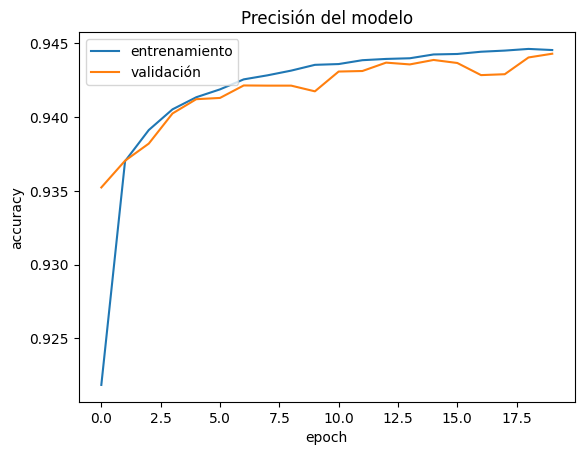

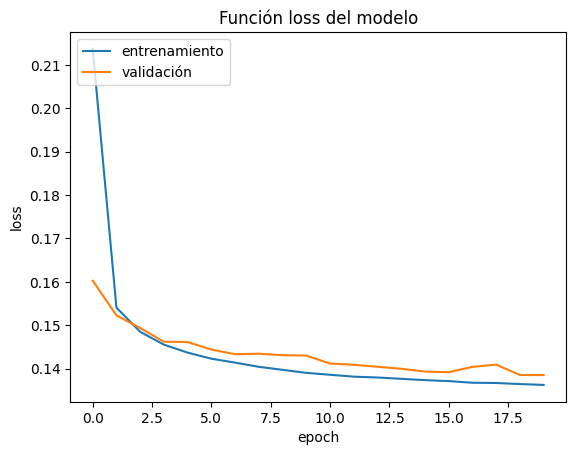

In [78]:
draw_histories(histories["M1"])

In [79]:
yValidatePredicted_M1_raw = M1.predict(xValidate)
yValidatePredicted_M1_class = yValidatePredicted_M1_raw.argmax(axis=-1)

evaluar_modelo(yValidate, yValidatePredicted_M1_class)

2588/2588 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Confusion matrix:
 [[42736   106  1838]
 [   87 27999    42]
 [ 2483    58  7463]]

Exactitud (accuracy): 0.944,

Kappa de Cohen: 0.903,

Clase 1. Selectividad (precision): 0.943, especificidad (recall): 0.956, f1: 0.950

Clase 2. Selectividad (precision): 0.994, especificidad (recall): 0.995, f1: 0.995

Clase 3. Selectividad (precision): 0.799, especificidad (recall): 0.746, f1: 0.771


#### Entrenar modelo ANN con hiperparametros ver. 2 (M2)

In [83]:
## Configurar el modelo
M2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(hiper['M2']['internal1'], activation='relu'),
    keras.layers.Dense(hiper['M2']['internal2'], activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

# Define the accuracy metrics and parameters
M2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print('TensorFlow version:', tf.version.VERSION)
print('epochs=',hiper['M2']['epochs'],'batch=',hiper['M2']['batch'])
print(M2.summary())

histories['M2']  = model_fit(M2, xTrain, yTrain,
                             xValidate, yValidate,
                             epochs=hiper['M2']['epochs'], batch=hiper['M2']['batch'])

TensorFlow version: 2.17.1
epochs= 20 batch= 50


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_15 (Flatten)                 │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 40)                  │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 10)                  │             410 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 723 (2.82 KB)

 Trainable params: 723 (2.82 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9307 - loss: 0.1832 - val_accuracy: 0.9366 - val_loss: 0.1506
Epoch 2/20
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9408 - loss: 0.1455 - val_accuracy: 0.9420 - val_loss: 0.1426
Epoch 3/20
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9427 - loss: 0.1415 - val_accuracy: 0.9415 - val_loss: 0.1426
Epoch 4/20
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9436 - loss: 0.1386 - val_accuracy: 0.9419 - val_loss: 0.1429
Epoch 5/20
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9440 - loss: 0.1388 - val_accuracy: 0.9432 - val_loss: 0.1397
Epoch 6/20
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9445 - loss: 0.1372 - val_accuracy: 0.9440 - val_loss: 0.1401
Epoch 7/20
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9447 - loss: 0.1369 - val_accuracy: 0.9421 - val_loss: 0.1419
Epoch 8/20
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accur

#### Guardado del modelo M2 en Google Drive

In [84]:
ruta_modelo_M2 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_ANN_M2.keras"
print(ruta_modelo_M2)

M2.save(ruta_modelo_M2)

/content/drive/MyDrive/Colab Data/ESE_2015_ANN_M2.keras


#### Presentar graficas de avance de entrenamiento del modelo M2 y evaluar con el subconjunto de validación

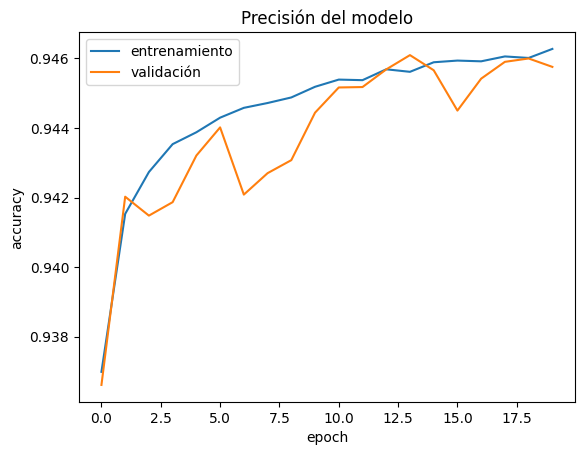

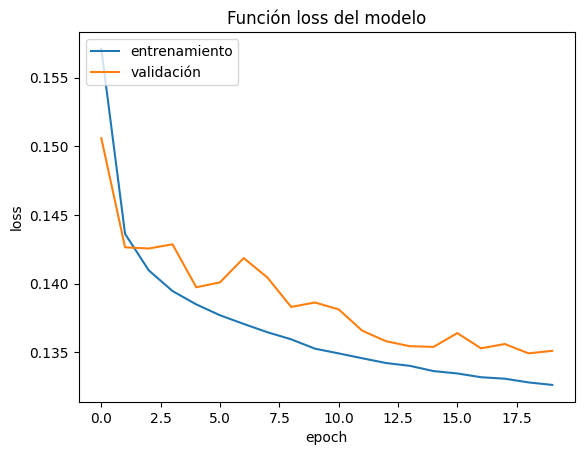

In [85]:
draw_histories(histories["M2"])

In [86]:
yValidatePredicted_M2_raw = M2.predict(xValidate)
yValidatePredicted_M2_class = yValidatePredicted_M2_raw.argmax(axis=-1)

evaluar_modelo(yValidate, yValidatePredicted_M2_class)

2588/2588 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Confusion matrix:
 [[42803    95  1782]
 [  103 27987    38]
 [ 2423    51  7530]]

Exactitud (accuracy): 0.946,

Kappa de Cohen: 0.906,

Clase 1. Selectividad (precision): 0.944, especificidad (recall): 0.958, f1: 0.951

Clase 2. Selectividad (precision): 0.995, especificidad (recall): 0.995, f1: 0.995

Clase 3. Selectividad (precision): 0.805, especificidad (recall): 0.753, f1: 0.778


## La evaluación con datos de validación permite eligir el modleo M2
#### Evaluación del modelo elegido con datos de control

In [87]:
M_elegido = M2

yTestPredicted_M_elegido_raw = M_elegido.predict(xTest)
yTestPredicted_M_elegido_class = yTestPredicted_M_elegido_raw.argmax(axis=-1)

evaluar_modelo(yTest, yTestPredicted_M_elegido_class)

2588/2588 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Confusion matrix:
 [[43008   105  1717]
 [  106 27898    34]
 [ 2341    38  7565]]

Exactitud (accuracy): 0.948,

Kappa de Cohen: 0.909,

Clase 1. Selectividad (precision): 0.946, especificidad (recall): 0.959, f1: 0.953

Clase 2. Selectividad (precision): 0.995, especificidad (recall): 0.995, f1: 0.995

Clase 3. Selectividad (precision): 0.812, especificidad (recall): 0.761, f1: 0.786


#### Prediccion para 2015

In [88]:
x_features_2015_full = x_features_2015_n.reshape((x_features_2015_n.shape[0], 1, x_features_2015_n.shape[1]))

predicted_2015 = M_elegido.predict(x_features_2015_full)
print(predicted_2015)

25879/25879 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
[[9.9895430e-01 1.6104331e-04 8.8472775e-04]
 [9.9767727e-01 5.7802557e-05 2.2649509e-03]
 [9.9290359e-01 4.3790762e-05 7.0526185e-03]
 ...
 [9.9976945e-01 3.7440757e-05 1.9311570e-04]
 [9.9970615e-01 1.3276149e-04 1.6116007e-04]
 [9.9979925e-01 9.2447881e-05 1.0839519e-04]]


#### Visualizar predicción 2015

Predicción de clases


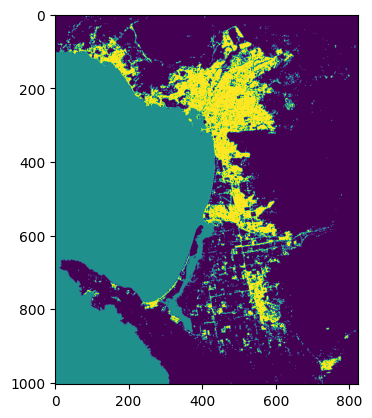

Probabilidad de presencia del espacio construido


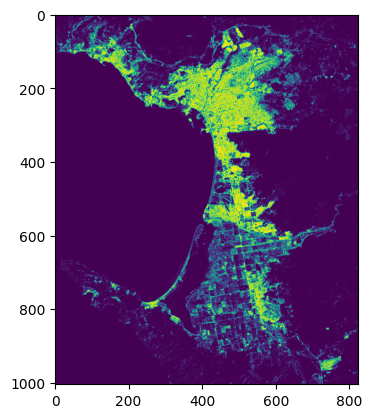

In [89]:
print('Predicción de clases')
predicted_2015_class = predicted_2015.argmax(axis=-1)
predicted_2015_class_re = np.reshape(predicted_2015_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2015_class_re[:,:])
plt.show()

print('Probabilidad de presencia del espacio construido')
predicted_2015_probability = np.reshape(predicted_2015[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2015 = (predicted_2015_probability).astype('float')
plt.imshow(B_img_pred_2015[:,:])
plt.show()

#### Predicción para 2014

In [90]:
x_features_2014_full = x_features_2014_n.reshape((x_features_2014_n.shape[0], 1, x_features_2014_n.shape[1]))

predicted_2014 = M_elegido.predict(x_features_2014_full)
print(predicted_2014)

25879/25879 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
[[9.9942720e-01 3.8605940e-05 5.3406041e-04]
 [9.9852186e-01 1.1435172e-05 1.4666294e-03]
 [9.9825114e-01 8.8625329e-06 1.7400779e-03]
 ...
 [9.9976945e-01 9.3740491e-05 1.3678773e-04]
 [9.9966693e-01 1.9263919e-04 1.4040203e-04]
 [9.9963701e-01 2.3558021e-04 1.2739944e-04]]


#### Visualiziación para 2014

Predicción de clases


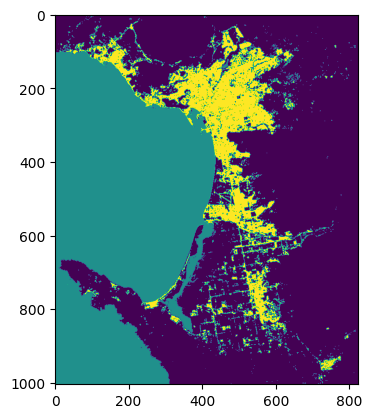

Probabilidad de presencia del espacio construido


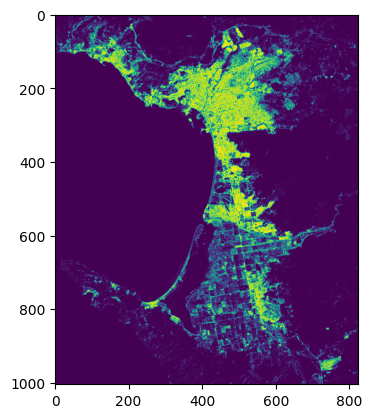

In [91]:
print('Predicción de clases')
predicted_2014_class = predicted_2014.argmax(axis=-1)
predicted_2014_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2014_class_re[:,:])
plt.show()

print('Probabilidad de presencia del espacio construido')
predicted_2014_probability = np.reshape(predicted_2015[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2014 = (predicted_2014_probability).astype('float')
plt.imshow(B_img_pred_2014[:,:])
plt.show()

#### Predicción para 2020

In [92]:
x_features_2020_full = x_features_2020_n.reshape((x_features_2020_n.shape[0], 1, x_features_2020_n.shape[1]))

predicted_2020 = M_elegido.predict(x_features_2020_full)
print(predicted_2020)

25879/25879 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step
[[9.87322628e-01 1.37851795e-03 1.12987859e-02]
 [9.80872095e-01 3.63938540e-04 1.87639631e-02]
 [9.87357736e-01 4.34657646e-04 1.22074345e-02]
 ...
 [9.98241246e-01 3.57354729e-04 1.40137842e-03]
 [9.98244107e-01 4.18980635e-04 1.33685395e-03]
 [9.98495698e-01 3.63489467e-04 1.14062289e-03]]


#### Visualización para 2020

Predicción de clases


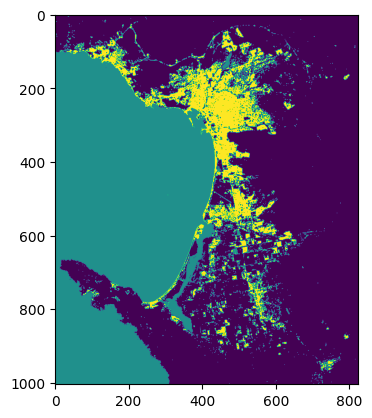

Probabilidad de presencia del espacio construido


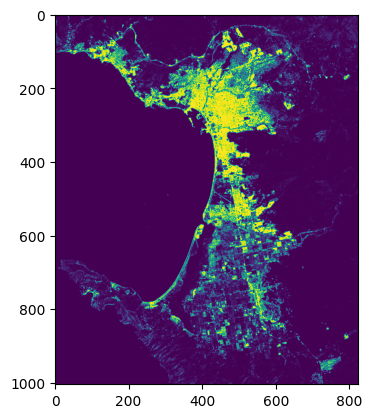

In [93]:
print('Predicción de clases')
predicted_2020_class = predicted_2020.argmax(axis=-1)
predicted_2020_class_re = np.reshape(predicted_2020_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2020_class_re[:,:])
plt.show()

print('Probabilidad de presencia del espacio construido')
predicted_2020_probability = np.reshape(predicted_2020[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2020 = (predicted_2020_probability).astype('float')
plt.imshow(B_img_pred_2020[:,:])
plt.show()

#### Guardar resultados en Numpy array en Google Drive

In [94]:
ruta_clases_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_clasificado.npy"
ruta_probabilidad_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_probabilidad.npy"
print(ruta_clases_2015)
print(ruta_probabilidad_2015)

ruta_clases_2014 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2014_clasificado.npy"
ruta_probabilidad_2014 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2014_probabilidad.npy"
print(ruta_clases_2014)
print(ruta_probabilidad_2014)

ruta_clases_2020 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2020_clasificado.npy"
ruta_probabilidad_2020 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2020_probabilidad.npy"
print(ruta_clases_2020)
print(ruta_probabilidad_2020)

np.save(ruta_clases_2015, predicted_2015_class_re)
np.save(ruta_probabilidad_2015, predicted_2015_probability)

np.save(ruta_clases_2014, predicted_2014_class_re)
np.save(ruta_probabilidad_2014, predicted_2014_probability)

np.save(ruta_clases_2020, predicted_2020_class_re)
np.save(ruta_probabilidad_2020, predicted_2020_probability)

/content/drive/MyDrive/Colab Data/ESE_2015_clasificado.npy
/content/drive/MyDrive/Colab Data/ESE_2015_probabilidad.npy
/content/drive/MyDrive/Colab Data/ESE_2014_clasificado.npy
/content/drive/MyDrive/Colab Data/ESE_2014_probabilidad.npy
/content/drive/MyDrive/Colab Data/ESE_2020_clasificado.npy
/content/drive/MyDrive/Colab Data/ESE_2020_probabilidad.npy


#### Preparar guardado en GeoTIFF

In [95]:
def write_geotiff(arr, filename, proj, transform):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32
    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(proj)
    out_ds.SetGeoTransform(transform)
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)


sr = osr.SpatialReference()
sr.ImportFromEPSG(int(projection_text.replace(projection_text[:5], '')))


## Nota: todos arrays deben ser de mismo número de pixeles de ancho y alto
## solo se calculan para target 2015

ancho_px_esperado = math.ceil((limites_utm[1] - limites_utm[0]) / pixel)
print('Ancho total esperado (pixeles)', ancho_px_esperado)
ancho_px_observado = array_target_2015.shape[1]
print('Ancho total observado (pixeles)', ancho_px_observado)
pixel_x = pixel * ancho_px_esperado / ancho_px_observado

alto_px_esperado = math.ceil((limites_utm[3] - limites_utm[2]) / pixel)
print('Alto total esperado (pixeles)', alto_px_esperado)
alto_px_observado = array_target_2015.shape[0]
print('Alto total observado (pixeles)', alto_px_observado)
pixel_y = pixel * alto_px_esperado / alto_px_observado

geotrans = [limites_utm[0], pixel_x, 0, limites_utm[3], 0, -pixel_y]

print(geotrans)
#print(sr)
print(sr.ExportToWkt())

Ancho total esperado (pixeles) 824
Ancho total observado (pixeles) 824
Alto total esperado (pixeles) 1005
Alto total observado (pixeles) 1005
[523989, 30.0, 0, 3532709, 0, -30.0]
PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


#### Guardar como GeoTIFFs en Google Drive

In [96]:
ruta_clases_2015_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_clasificado.tif"
ruta_probabilidad_2015_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_probabilidad.tif"
print(ruta_clases_2015_tif)
print(ruta_probabilidad_2015_tif)

ruta_clases_2014_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2014_clasificado.tif"
ruta_probabilidad_2014_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2014_probabilidad.tif"
print(ruta_clases_2014_tif)
print(ruta_probabilidad_2014_tif)

ruta_clases_2020_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2020_clasificado.tif"
ruta_probabilidad_2020_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2020_probabilidad.tif"
print(ruta_clases_2020_tif)
print(ruta_probabilidad_2020_tif)


write_geotiff(predicted_2015_class_re, filename=ruta_clases_2015_tif, proj=sr.ExportToWkt(), transform=geotrans)
write_geotiff(predicted_2015_probability, filename=ruta_probabilidad_2015_tif, proj=sr.ExportToWkt(), transform=geotrans)

write_geotiff(predicted_2014_class_re, filename=ruta_clases_2014_tif, proj=sr.ExportToWkt(), transform=geotrans)
write_geotiff(predicted_2014_probability, filename=ruta_probabilidad_2014_tif, proj=sr.ExportToWkt(), transform=geotrans)

write_geotiff(predicted_2020_class_re, filename=ruta_clases_2020_tif, proj=sr.ExportToWkt(), transform=geotrans)
write_geotiff(predicted_2020_probability, filename=ruta_probabilidad_2020_tif, proj=sr.ExportToWkt(), transform=geotrans)

/content/drive/MyDrive/Colab Data/ESE_2015_clasificado.tif
/content/drive/MyDrive/Colab Data/ESE_2015_probabilidad.tif
/content/drive/MyDrive/Colab Data/ESE_2014_clasificado.tif
/content/drive/MyDrive/Colab Data/ESE_2014_probabilidad.tif
/content/drive/MyDrive/Colab Data/ESE_2020_clasificado.tif
/content/drive/MyDrive/Colab Data/ESE_2020_probabilidad.tif
